In [3]:
# Look for similiar patters in the past using KNN
# Use commodities

In [55]:
# import numpy as np
import pandas as pd
import numpy as np
import yfinance as yf
from autoIG import tickers
import plotnine as pn

In [57]:
START_DATE = "2008-06-01"
END_DATE = "2020-06-01"
INTERVAL  = "1d"
history_config =  {"start":START_DATE,"end":END_DATE,"interval":INTERVAL}
gold = yf.Ticker(tickers.GOLD_TICKER)

In [7]:
history_raw = gold.history(**history_config)
history = history_raw.reset_index()
history = history.reset_index()
history.head(3)

,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0,2008-06-02,887.299988,898.000000,881.799988,892.900024,2132,0,0
1,1,2008-06-03,889.799988,896.099976,874.599976,881.599976,2079,0,0
2,2,2008-06-04,879.500000,886.099976,876.000000,879.900024,612,0,0


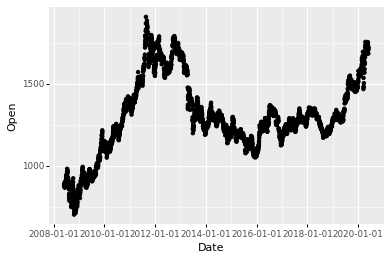

<ggplot: (310210807)>

In [10]:
(
    pn.ggplot(history)+
    pn.geom_point(pn.aes('Date','Open'))+
    pn.theme(figure_size=[12,3])
)


In [80]:
import datetime
import dateutil
from dateutil.relativedelta import relativedelta
START_10_DATE = (dateutil.parser.parse(START_DATE) + relativedelta(years=10)).strftime(format = "%Y-%m-%d")
train = history.query(f"Date < '{START_10_DATE}'")
test = history.query(f"Date > '{START_10_DATE}'")

In [ ]:
from sklearn.pipeline import Pipeline


In [164]:
transform_to_knn(train,n=3)


['m3', 'm2', 'm1', 'm0']


,m3,m2,m1,m0
0,1.0,1.002818,0.991209,-0.012623
1,1.0,0.988424,0.984603,-0.012699
2,1.0,0.996134,0.998863,0.024105
3,1.0,1.002739,1.028079,0.011985
4,1.0,1.025270,1.009220,-0.010245
...,...,...,...,...
2507,1.0,1.003340,1.001476,0.012661
2508,1.0,0.998142,1.009290,0.008980
2509,1.0,1.011169,1.010859,0.007291
2510,1.0,0.999693,0.996165,-0.004372


In [166]:
def transform_to_knn(df,n = 3):
    s = df.Open.to_list()
    col_names = ["m"+str(n-i) for i in range(n+1)]
    df_transformed = pd.DataFrame(
        [dict(zip(col_names, s[i : (i + n+1) ])) for i in range(len(s) - (n-1) )]
    )

    for i in col_names[::-1]:
        df_transformed[i] = df_transformed[i] / df_transformed[col_names[0]]

    df_transformed = df_transformed.assign(m0=lambda df: df["m0"]-1)
    df_transformed= df_transformed.iloc[0:-1,:]
    return df_transformed
transform_to_knn(train.iloc[0:10,:],n= 5)

,m5,m4,m3,m2,m1,m0
0,1.0,1.002818,0.991209,0.987377,0.990082,0.015102
1,1.0,0.988424,0.984603,0.987301,1.012250,-0.003596
2,1.0,0.996134,0.998863,1.024105,1.008073,-0.011370
3,1.0,1.002739,1.028079,1.011985,0.992467,-0.002854
4,1.0,1.025270,1.009220,0.989755,0.994422,-0.009334


In [167]:
df_test = transform_to_knn(test,n=3)


In [100]:
# check for NAs
df.iloc[df.isna().sum(axis = 1).astype(bool).to_list(),:]

,m3,m2,m1,m0


In [168]:
from sklearn.neighbors import KNeighborsRegressor
knnreg = KNeighborsRegressor(n_neighbors=5)

knnreg.fit(X=df[['m3','m2','m1']],y = df.m0)
preds = knnreg.predict(df_test[['m3','m2','m1']])
df_test = df_test.assign(preds =  preds)

In [169]:
from  sklearn.metrics import confusion_matrix,mean_squared_error

In [170]:
mean_squared_error(df_test.m0,df_test.preds)

0.0001339917648789515

In [179]:
df_test = df_test.assign(diff = lambda df: df.preds- df.m0)
df_test.head()

,m3,m2,m1,m0,preds,diff
0,1.0,0.998609,1.001700,0.003478,0.000798,-0.002680
1,1.0,1.003096,1.004876,0.002477,0.011788,0.009311
2,1.0,1.001775,0.999383,0.002469,0.006370,0.003901
3,1.0,0.997612,1.000693,-0.000462,0.003020,0.003482
4,1.0,1.003088,1.001930,-0.001004,0.006627,0.007630


/Users/ezracitron/my_projects/autoIG/.venv/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 43'. Pick better value with 'binwidth'.


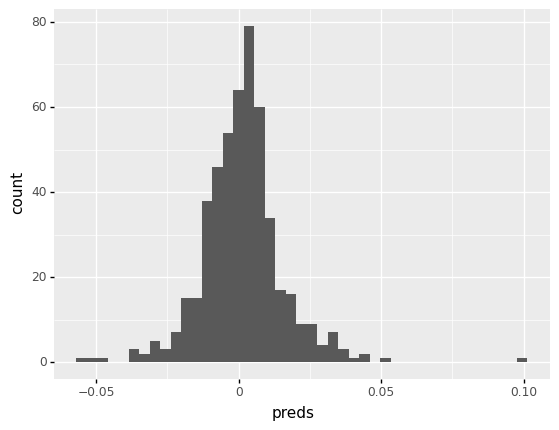

<ggplot: (318337567)>

In [174]:
import plotnine as pn
from plotnine import ggplot, aes, geom_point, geom_col, theme, geom_point,scale_x_continuous ,scale_y_continuous, geom_histogram, geom_line, labs
(
    ggplot(df_test)+
    pn.geom_histogram(aes('preds'))+
    theme()
)

/Users/ezracitron/my_projects/autoIG/.venv/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 52'. Pick better value with 'binwidth'.


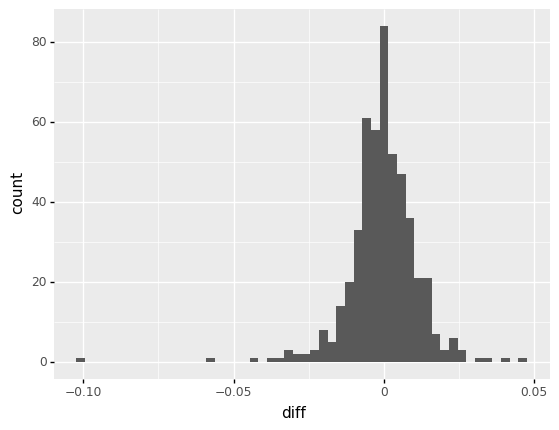

<ggplot: (310977555)>

In [178]:
import plotnine as pn
from plotnine import ggplot, aes, geom_point, geom_col, theme, geom_point,scale_x_continuous ,scale_y_continuous, geom_histogram, geom_line, labs
(
    ggplot(df_test)+
    pn.geom_histogram(aes('diff'))+
    theme()
)

In [187]:
# how many times did we predict up and it went down and vice versa
df_test = df_test.assign(preds_bool= lambda df: (df.preds * df.m0> 0).astype(int) )  # this cleverly checks if theyre the same sign


In [193]:
# now we check how many went does when my algo said it preds was above 0.01
df_test = df_test.assign(confident_preds = lambda df: (df.preds>0.01).astype(int), m0_above_0 = lambda df: (df.m0>0).astype(int) )
df_test.head()

,m3,m2,m1,m0,preds,diff,preds_bool,confident_preds,m0_above_0
0,1.0,0.998609,1.001700,0.003478,0.000798,-0.002680,1,0,1
1,1.0,1.003096,1.004876,0.002477,0.011788,0.009311,1,1,1
2,1.0,1.001775,0.999383,0.002469,0.006370,0.003901,1,0,1
3,1.0,0.997612,1.000693,-0.000462,0.003020,0.003482,0,0,0
4,1.0,1.003088,1.001930,-0.001004,0.006627,0.007630,0,0,0


In [196]:
df_test.value_counts(['confident_preds','m0_above_0']).reset_index().rename(columns = {0:'value'})

,confident_preds,m0_above_0,value
0,0,0,232
1,0,1,173
2,1,1,89
3,1,0,4


In [129]:
# is there any value that beats it?
for i in np.arange(-0.05,0.05,0.005):
    print(f"{i}: {mean_squared_error(df_test.m0,[i]*len(df_test))}")

-0.05: 0.0029935118806478397
-0.045000000000000005: 0.002500373541784269
-0.04000000000000001: 0.0020572352029206973
-0.03500000000000001: 0.0016640968640571259
-0.030000000000000013: 0.0013209585251935543
-0.025000000000000015: 0.001027820186329983
-0.020000000000000018: 0.0007846818474664115
-0.01500000000000002: 0.0005915435086028397
-0.010000000000000023: 0.00044840516973926797
-0.005000000000000025: 0.00035526683087569623
-2.7755575615628914e-17: 0.00031212849201212446
0.00499999999999997: 0.00031899015314855266
0.009999999999999967: 0.00037585181428498077
0.014999999999999972: 0.000482713475421409
0.019999999999999962: 0.0006395751365578368
0.024999999999999953: 0.0008464367976942647
0.029999999999999957: 0.0011032984588306928
0.03499999999999996: 0.001410160119967121
0.03999999999999995: 0.0017670217811035485
0.04499999999999994: 0.0021738834422399757
